<a href="https://colab.research.google.com/github/chaerui7967/stock_predict_news_and_youtube/blob/master/%ED%98%84%EB%8C%80%EC%B0%A8_%ED%86%B5%ED%95%A9%ED%85%8C%EC%9D%B4%EB%B8%94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 오늘 시작

## 라이브러리 설치

In [1]:
!pip install finance-datareader
!pip install pykrx
!pip install pymysql
!pip install konlpy
from konlpy.tag import Okt
okt = Okt()

     |████████████████████████████████| 70 kB 3.8 MB/s 
     |████████████████████████████████| 60 kB 7.1 MB/s 
     |████████████████████████████████| 251 kB 34.1 MB/s 
     |████████████████████████████████| 43 kB 1.2 MB/s 
     |████████████████████████████████| 19.4 MB 1.5 MB/s 
     |████████████████████████████████| 448 kB 33.0 MB/s 
     |████████████████████████████████| 86 kB 5.6 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


## 패키지 & 함수 로딩

In [2]:
# 필요 라이브러리
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# 주식가격 로딩
import FinanceDataReader as fdr
from pykrx import stock

import datetime

In [3]:
def money_sur(stock_name, start, end):

    start_date = start
    end_date = end
    sample_code = stock_name

    dataset = fdr.DataReader(sample_code, start = start_date, end = end_date )
    dataset = dataset.reset_index()
    df = stock.get_market_fundamental_by_date(fromdate=start_date, todate=end_date, ticker=sample_code)
    df = df.reset_index()
    df.columns = ['Date','BPS', 'PER', 'PBR', 'EPS', 'DIV', 'DPS']
    data = pd.merge(dataset, df, on='Date')

    return data

In [4]:
def reverse_min_max_scaling(org_x, x): #종가 예측값
    org_x_np = np.asarray(org_x) 
    x_np = np.asarray(x)
    return (x_np * (org_x_np.max() - org_x_np.min())) + org_x_np.min()

## 통합테이블 생성

In [5]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# total_table = pd.read_csv('/content/drive/My Drive/Final PJT - 업빛투/total_table.csv') # 기존 테이블

In [7]:
# 구성
dic = {'code' : [],
       'date' : [],
       'lstm' : [],
       'arima' : [],
       'fbprophet' : [],
       'RL' : [],
    #    'mail_news' : [],
    #    'mail_news_nsi' : [],
    #    'asia_news' : [],
    #    'asia_news_nsi': [],
    #    'youtube_sam' : [],
    #    'youtube_su' : [],
    #    'youtube_han' : [],
       'close' : []}

total_table = pd.DataFrame(dic)

In [8]:
total_table.columns

Index(['code', 'date', 'lstm', 'arima', 'fbprophet', 'RL', 'close'], dtype='object')

In [9]:
total_table

,code,date,lstm,arima,fbprophet,RL,close


## LSTM 예측결과

### 사용 데이터 로드 및 전처리

In [10]:
end_date = datetime.datetime.now().strftime("%Y%m%d")
lstm = money_sur('005380', '2018', end_date)

In [11]:
lstm = lstm.set_index('Date')

In [12]:
lstm.head()

,Open,High,Low,Close,Volume,Change,BPS,PER,PBR,EPS,DIV,DPS
Date,,,,,,,,,,,,
2018-01-02,150500,153000,149000,149500,731763,-0.041667,235358,7.43,0.64,20118,2.68,4000
2018-01-03,149000,151000,149000,150500,450874,0.006689,235358,7.48,0.64,20118,2.66,4000
2018-01-04,150500,151000,146000,146500,931558,-0.026578,235358,7.28,0.62,20118,2.73,4000
2018-01-05,146000,149000,145500,149000,463695,0.017065,235358,7.41,0.63,20118,2.68,4000
2018-01-08,148500,151000,147500,151000,482619,0.013423,235358,7.51,0.64,20118,2.65,4000


In [13]:
# 스케일링
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()
lstm_sc = sc.fit_transform(lstm)

In [14]:
scale_cols = lstm.columns
lstm_sc_df = pd.DataFrame(lstm_sc, columns=[scale_cols], index=lstm.index)

In [15]:
lstm_sc_df.head()

,Open,High,Low,Close,Volume,Change,BPS,PER,PBR,EPS,DIV,DPS
Date,,,,,,,,,,,,
2018-01-02,0.408734,0.376147,0.431877,0.414683,0.027945,0.207458,0.0,0.032241,0.468354,1.0,0.299587,1.0
2018-01-03,0.401374,0.366972,0.431877,0.419643,0.013725,0.369957,0.0,0.033541,0.468354,1.0,0.295455,1.0
2018-01-04,0.408734,0.366972,0.416452,0.399802,0.038059,0.258163,0.0,0.028341,0.443038,1.0,0.309917,1.0
2018-01-05,0.386654,0.357798,0.413882,0.412202,0.014374,0.404825,0.0,0.031721,0.455696,1.0,0.299587,1.0
2018-01-08,0.398921,0.366972,0.424165,0.422123,0.015332,0.392586,0.0,0.034321,0.468354,1.0,0.293388,1.0


In [16]:
for i in scale_cols:
  for s in range(1, 11):  
    lstm_sc_df[(i+'shift_{}'.format(s),)] = lstm_sc_df[(i,)].shift(s)

In [17]:
lstm_sc_df.dropna()

,Open,High,Low,Close,Volume,Change,BPS,PER,PBR,EPS,DIV,DPS,Openshift_1,Openshift_2,Openshift_3,Openshift_4,Openshift_5,Openshift_6,Openshift_7,Openshift_8,Openshift_9,Openshift_10,Highshift_1,Highshift_2,Highshift_3,Highshift_4,Highshift_5,Highshift_6,Highshift_7,Highshift_8,Highshift_9,Highshift_10,Lowshift_1,Lowshift_2,Lowshift_3,Lowshift_4,Lowshift_5,Lowshift_6,Lowshift_7,Lowshift_8,...,PBRshift_1,PBRshift_2,PBRshift_3,PBRshift_4,PBRshift_5,PBRshift_6,PBRshift_7,PBRshift_8,PBRshift_9,PBRshift_10,EPSshift_1,EPSshift_2,EPSshift_3,EPSshift_4,EPSshift_5,EPSshift_6,EPSshift_7,EPSshift_8,EPSshift_9,EPSshift_10,DIVshift_1,DIVshift_2,DIVshift_3,DIVshift_4,DIVshift_5,DIVshift_6,DIVshift_7,DIVshift_8,DIVshift_9,DIVshift_10,DPSshift_1,DPSshift_2,DPSshift_3,DPSshift_4,DPSshift_5,DPSshift_6,DPSshift_7,DPSshift_8,DPSshift_9,DPSshift_10
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-16,0.423454,0.399083,0.452442,0.456845,0.013202,0.412520,0.000000,0.043162,0.506329,1.0,0.268595,1.0,0.425908,0.423454,0.435721,0.418548,0.411187,0.398921,0.386654,0.408734,0.401374,0.408734,0.385321,0.389908,0.392202,0.399083,0.373853,0.366972,0.357798,0.366972,0.366972,0.376147,0.442159,0.455013,0.449871,0.447301,0.434447,0.424165,0.413882,0.416452,...,0.493671,0.481013,0.493671,0.493671,0.481013,0.468354,0.455696,0.443038,0.468354,0.468354,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.278926,0.283058,0.278926,0.276859,0.287190,0.293388,0.299587,0.309917,0.295455,0.299587,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2018-01-17,0.440628,0.403670,0.467866,0.454365,0.009278,0.336844,0.000000,0.042642,0.506329,1.0,0.270661,1.0,0.423454,0.425908,0.423454,0.435721,0.418548,0.411187,0.398921,0.386654,0.408734,0.401374,0.399083,0.385321,0.389908,0.392202,0.399083,0.373853,0.366972,0.357798,0.366972,0.366972,0.452442,0.442159,0.455013,0.449871,0.447301,0.434447,0.424165,0.413882,...,0.506329,0.493671,0.481013,0.493671,0.493671,0.481013,0.468354,0.455696,0.443038,0.468354,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.268595,0.278926,0.283058,0.278926,0.276859,0.287190,0.293388,0.299587,0.309917,0.295455,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2018-01-18,0.443081,0.399083,0.457584,0.441964,0.007337,0.294138,0.000000,0.039262,0.493671,1.0,0.278926,1.0,0.440628,0.423454,0.425908,0.423454,0.435721,0.418548,0.411187,0.398921,0.386654,0.408734,0.403670,0.399083,0.385321,0.389908,0.392202,0.399083,0.373853,0.366972,0.357798,0.366972,0.467866,0.452442,0.442159,0.455013,0.449871,0.447301,0.434447,0.424165,...,0.506329,0.506329,0.493671,0.481013,0.493671,0.493671,0.481013,0.468354,0.455696,0.443038,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.270661,0.268595,0.278926,0.283058,0.278926,0.276859,0.287190,0.293388,0.299587,0.309917,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2018-01-19,0.430815,0.417431,0.460154,0.476687,0.023160,0.499243,0.000000,0.048362,0.531646,1.0,0.256198,1.0,0.443081,0.440628,0.423454,0.425908,0.423454,0.435721,0.418548,0.411187,0.398921,0.386654,0.399083,0.403670,0.399083,0.385321,0.389908,0.392202,0.399083,0.373853,0.366972,0.357798,0.457584,0.467866,0.452442,0.442159,0.455013,0.449871,0.447301,0.434447,...,0.493671,0.506329,0.506329,0.493671,0.481013,0.493671,0.493671,0.481013,0.468354,0.455696,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.278926,0.270661,0.268595,0.278926,0.283058,0.278926,0.276859,0.287190,0.293388,0.299587,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2018-01-22,0.467615,0.426606,0.480720,0.479167,0.020389,0.357851,0.000000,0.049142,0.531646,1.0,0.254132,1.0,0.430815,0.443081,0.440628,0.423454,0.425908,0.423454,0.435721,0.418548,0.411187,0.398921,0.417431,0.399083,0.403670,0.399083,0.385321,0.389908,0.392202,0.399083,0.373853,0.366972,0.460154,0.457584,0.467866,0.452442,0.442159,0.455013,0.449871,0.447301,...,0.531646,0.493671,0.506329,0.506329,0.493671,0.481013,0.493671,0.493671,0.481013,0.468354,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.256198,0.278926,0.270661,0.268595,0.278926,0.283058,0.278926,0.276859,0.287190,0

In [18]:
X_test = lstm_sc_df.dropna().drop(columns=scale_cols, axis=1)
y_test = lstm_sc_df.dropna()[['Close']]

X_test= X_test.values
y_test = y_test.values

In [19]:
X_test

array([[0.42590775, 0.42345437, 0.4357213 , ..., 1.        , 1.        ,
        1.        ],
       [0.42345437, 0.42590775, 0.42345437, ..., 1.        , 1.        ,
        1.        ],
       [0.44062807, 0.42345437, 0.42590775, ..., 1.        , 1.        ,
        1.        ],
       ...,
       [0.63935231, 0.67124632, 0.67615309, ..., 0.        , 0.        ,
        0.        ],
       [0.65161923, 0.63935231, 0.67124632, ..., 0.        , 0.        ,
        0.        ],
       [0.64180569, 0.65161923, 0.63935231, ..., 0.        , 0.        ,
        0.        ]])

In [20]:
X_test_t = X_test.reshape(X_test.shape[0], 10, 12)

### 모델 로드

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda, Flatten, Dropout
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model = Sequential()

model.add(LSTM(64,
               input_shape = (10, 12),
               return_sequences= True))
model.add(Dropout(0.2))
model.add(Dense(32, activation = 'relu'))
model.add(LSTM(64,
               input_shape = (10, 12),
               return_sequences= True))
model.add(Dropout(0.2))
model.add(Dense(32, activation = 'tanh'))
model.add(LSTM(64,
               return_sequences = False))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(100, activation = 'relu'))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(1))


lstm_path = '/content/drive/My Drive/Final PJT - 업빛투/Regression/LSTM/'
hun_lstm = 'lstm_hundai.h5'

model.load_weights(lstm_path+hun_lstm)

### 모델 결과

In [22]:
pred = model.predict(X_test_t)

In [23]:
pred.shape, y_test.shape

((915, 1), (915, 1))

In [24]:
pred_act = reverse_min_max_scaling(lstm['Close'], pred)

In [25]:
total_table['date'] = lstm.index[10:]
total_table['lstm'] = pred_act[:]
total_table['close'] = lstm.Close[10:].values.reshape(-1,1)
total_table['code'] = '005380'
total_table['change'] = lstm.Change[10:].values.reshape(-1,1)

In [26]:
total_table

,code,date,lstm,arima,fbprophet,RL,close,change
0,005380,2018-01-16,135282.672119,NaN,NaN,NaN,158000,0.019355
1,005380,2018-01-17,137288.666630,NaN,NaN,NaN,157500,-0.003165
2,005380,2018-01-18,137463.437653,NaN,NaN,NaN,155000,-0.015873
3,005380,2018-01-19,137928.306103,NaN,NaN,NaN,162000,0.045161
4,005380,2018-01-22,138916.832733,NaN,NaN,NaN,162500,0.003086
...,...,...,...,...,...,...,...,...
910,005380,2021-09-28,198528.249168,NaN,NaN,NaN,201500,-0.012255
911,005380,2021-09-29,197831.760597,NaN,NaN,NaN,201500,0.000000
912,005380,2021-09-30,197023.460388,NaN,NaN,NaN,200000,-0.007444
913,005380,2021-10-01,196401.989555,NaN,NaN,NaN,193500,-0.032500


## arima 예측결과

In [27]:
end_date = datetime.datetime.now().strftime("%Y%m%d")
samsung_df = money_sur('005380', '2015', end_date)

In [28]:
df = samsung_df[['Date','Close']]
df.columns = ['Date', 'Price']

In [29]:
len(total_table['arima'])

915

In [30]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
# 학습, 테스트 데이터 분리
for ru in range(-len(total_table),0):
    rus = ru+1
    train = df[:ru]
    test = df[ru:]

    if ru >= -10:
      model = ARIMA(train.Price.values, order = (2,1,2))
      model_fit = model.fit(trend = 'nc', full_output = True, disp = True)
    else:
      model = ARIMA(train.Price.values, order = (3,2,0))
      model_fit = model.fit(trend = 'nc', full_output = True, disp = True)

    fore = model_fit.forecast(steps=1) # 오늘 예측

    # 오늘 예측 데이터
    pred_arima_y = fore[0].tolist()

    # 실제 오늘 데이터 
    test_y = test.Price.values

    # # 신뢰구간
    # # 예측 데이터 최소값
    # pred_y_lower = []
    # # 예측 데이터 최대값
    # pred_y_upper = []

    # for lower_upper in fore[2]:
    #     lower = lower_upper[0]
    #     upper = lower_upper[1]
    #     pred_y_lower.append(lower)
    #     pred_y_upper.append(upper)
    if rus == 0:
        total_table['arima'].iloc[ru:] = pred_arima_y
    else:
        total_table['arima'].iloc[ru:rus] = pred_arima_y

print(model_fit.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 1660
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -15753.159
Method:                       css-mle   S.D. of innovations           3199.970
Date:                Tue, 05 Oct 2021   AIC                          31516.317
Time:                        06:26:43   BIC                          31543.390
Sample:                             1   HQIC                         31526.352
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.D.y     -0.8539      0.104     -8.228      0.000      -1.057      -0.651
ar.L2.D.y     -0.8535      0.120     -7.096      0.000      -1.089      -0.618
ma.L1.D.y      0.9032      0.089     10.170      0.0

In [31]:
total_table

,code,date,lstm,arima,fbprophet,RL,close,change
0,005380,2018-01-16,135282.672119,155533.829514,NaN,NaN,158000,0.019355
1,005380,2018-01-17,137288.666630,158564.088827,NaN,NaN,157500,-0.003165
2,005380,2018-01-18,137463.437653,158136.354455,NaN,NaN,155000,-0.015873
3,005380,2018-01-19,137928.306103,155389.057578,NaN,NaN,162000,0.045161
4,005380,2018-01-22,138916.832733,163682.418749,NaN,NaN,162500,0.003086
...,...,...,...,...,...,...,...,...
910,005380,2021-09-28,198528.249168,204069.138361,NaN,NaN,201500,-0.012255
911,005380,2021-09-29,197831.760597,201289.998338,NaN,NaN,201500,0.000000
912,005380,2021-09-30,197023.460388,201647.683339,NaN,NaN,200000,-0.007444
913,005380,2021-10-01,196401.989555,200070.959373,NaN,NaN,193500,-0.032500


## fbprophet 예측

In [32]:
end_date = datetime.datetime.now().strftime("%Y%m%d")
samsung_df = money_sur('005380', start = '20180101', end = end_date)
df1 = samsung_df[['Date','Close']]
df1.columns = ['ds', 'y']

from fbprophet import Prophet

prophet = Prophet(seasonality_mode = 'multiplicative',
                 yearly_seasonality=True, 
                 weekly_seasonality=True,
                 daily_seasonality=True,
                 changepoint_prior_scale=0.6)

prophet.fit(df1)

# 10일단위로 예측값을 가져옴
future_data = prophet.make_future_dataframe(periods = 10, freq = 'd')
forecast_data = prophet.predict(future_data)

In [33]:
list(total_table.date.values)

[numpy.datetime64('2018-01-16T00:00:00.000000000'),
 numpy.datetime64('2018-01-17T00:00:00.000000000'),
 numpy.datetime64('2018-01-18T00:00:00.000000000'),
 numpy.datetime64('2018-01-19T00:00:00.000000000'),
 numpy.datetime64('2018-01-22T00:00:00.000000000'),
 numpy.datetime64('2018-01-23T00:00:00.000000000'),
 numpy.datetime64('2018-01-24T00:00:00.000000000'),
 numpy.datetime64('2018-01-25T00:00:00.000000000'),
 numpy.datetime64('2018-01-26T00:00:00.000000000'),
 numpy.datetime64('2018-01-29T00:00:00.000000000'),
 numpy.datetime64('2018-01-30T00:00:00.000000000'),
 numpy.datetime64('2018-01-31T00:00:00.000000000'),
 numpy.datetime64('2018-02-01T00:00:00.000000000'),
 numpy.datetime64('2018-02-02T00:00:00.000000000'),
 numpy.datetime64('2018-02-05T00:00:00.000000000'),
 numpy.datetime64('2018-02-06T00:00:00.000000000'),
 numpy.datetime64('2018-02-07T00:00:00.000000000'),
 numpy.datetime64('2018-02-08T00:00:00.000000000'),
 numpy.datetime64('2018-02-09T00:00:00.000000000'),
 numpy.datet

In [34]:
total_table['fbprophet'] = forecast_data[forecast_data['ds'].isin(list(total_table.date.values))]['yhat'].values

In [35]:
total_table

,code,date,lstm,arima,fbprophet,RL,close,change
0,005380,2018-01-16,135282.672119,155533.829514,160184.704622,NaN,158000,0.019355
1,005380,2018-01-17,137288.666630,158564.088827,160968.264614,NaN,157500,-0.003165
2,005380,2018-01-18,137463.437653,158136.354455,161350.367342,NaN,155000,-0.015873
3,005380,2018-01-19,137928.306103,155389.057578,161875.410838,NaN,162000,0.045161
4,005380,2018-01-22,138916.832733,163682.418749,162998.300483,NaN,162500,0.003086
...,...,...,...,...,...,...,...,...
910,005380,2021-09-28,198528.249168,204069.138361,204266.660514,NaN,201500,-0.012255
911,005380,2021-09-29,197831.760597,201289.998338,203401.717090,NaN,201500,0.000000
912,005380,2021-09-30,197023.460388,201647.683339,202086.007477,NaN,200000,-0.007444
913,005380,2021-10-01,196401.989555,200070.959373,201079.607698,NaN,193500,-0.032500


In [36]:
# total_table.to_csv('./total_table.csv', index =False)

## RL 결과

### 데이터 로딩 및 함수 로딩

In [37]:
import time
import copy
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F

# 금융정보 조회하기
def dataset_loaderKR(stock_name, start, end, train_ratio=0.8):
    start_date = start
    end_date = end
    sample_code = stock_name

    dataset = fdr.DataReader(sample_code, start = start_date, end = end_date )
    dataset = dataset.reset_index()
    df = stock.get_market_fundamental_by_date(fromdate=start_date, todate=end_date, ticker=sample_code)
    df = df.reset_index()
    df.columns = ['Date','BPS', 'PER', 'PBR', 'EPS', 'DIV', 'DPS']
    data = pd.merge(dataset, df, on='Date')
    date_split = data.index[int(train_ratio*len(data))] 

    return data[:date_split], data[date_split:], date_split


# ENV 설정
class Environment1:
    def __init__(self, data, history_t=90):
        self.data = data
        self.history_t = history_t
        self.reset()
        
    def reset(self):
        self.t = 0
        self.done = False
        self.profits = 0
        self.positions = []
        self.position_value = 0
        self.history = [0 for _ in range(self.history_t)]
        return [self.position_value] + self.history # obs

    def step(self, act):
        reward = 0
        
        # action
        # 0: Idle
        # 1: 매수
        # 2: 매도
        if act == 1: #매수
            self.positions.append(self.data.iloc[self.t, :]['Close'])
        elif act == 2: # 매도
            if len(self.positions) == 0:
                reward = -1
            else:
                profits = 0
                for p in self.positions:
                    profits += (self.data.iloc[self.t, :]['Close'] - p)
                reward += profits
                self.profits += profits
                self.positions = []
        
        # set next time
        self.t += 1
        
        self.position_value = 0
        for p in self.positions:
            self.position_value += (self.data.iloc[self.t, :]['Close'] - p)
        self.history.pop(0)
        self.history.append(self.data.iloc[self.t, :]['Close'] - self.data.iloc[(self.t-1), :]['Close'])
        if (self.t==len(self.data)-1):
            self.done=True
        # clipping reward
        if reward > 0:
            reward = 1
        elif reward < 0:
            reward = -1
        #print ("t={%d}, done={%str}"%(self.t,self.done))
        return [self.position_value] + self.history, reward, self.done # obs, reward, done

# MODEL
class Q_Network(nn.Module):
    def __init__(self,obs_len,hidden_size,actions_n):
        super(Q_Network,self).__init__()
        self.fc_val = nn.Sequential(
            nn.Linear(obs_len, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, actions_n)
        )
    def forward(self,x):
        h = self.fc_val(x)
        return (h)

In [38]:
(train, test, date_split) = dataset_loaderKR('005380', start = '2000', end = end_date)

### 모델 로딩 및 결과

In [39]:
rl_path = '/content/drive/My Drive/Final PJT - 업빛투/Regression/RL/현대차_결과/'
hun_rl = 'hyundai_rl_재무정보.h5'

In [40]:
# 모델 로딩
model = torch.load(rl_path+hun_rl)

test_env = Environment1(test)
pobs = test_env.reset()
test_acts = []
test_rewards = []

for _ in range(len(test_env.data)-1):
    pact = model(torch.from_numpy(np.array(pobs, dtype=np.float32).reshape(1, -1)))
    pact = np.argmax(pact.data)
    test_acts.append(pact.item())
            
    obs, reward, done = test_env.step(pact.numpy())
    test_rewards.append(reward)

    pobs = obs

# sell remaining stocks
profits = 0
for p in test_env.positions:
	profits += (test_env.data.iloc[test_env.t, :]['Close'] - p)

test_env.profits += profits
test_env.positions = []

test_profits = test_env.profits
pact = model(torch.from_numpy(np.array(pobs, dtype=np.float32).reshape(1, -1)))
pact = np.argmax(pact.data)
next_action = pact.item()
test['Action'] = test_acts + [next_action]


print( )
print( test )
print( )
print("결과")
print( "손익결과 $%.2f" % round(test_profits,2) )
# 0: Idle
# 1: 매수
# 2: 매도


           Date    Open    High     Low  ...    EPS   DIV   DPS  Action
4296 2017-05-22  169000  171000  167000  ...  20118  2.35  4000       1
4297 2017-05-23  170000  173000  169000  ...  20118  2.35  4000       1
4298 2017-05-24  168500  170000  163500  ...  20118  2.44  4000       2
4299 2017-05-25  164500  167000  163500  ...  20118  2.42  4000       0
4300 2017-05-26  165500  166500  163000  ...  20118  2.45  4000       2
...         ...     ...     ...     ...  ...    ...   ...   ...     ...
5366 2021-09-28  204000  204000  200500  ...   5454  1.49  3000       1
5367 2021-09-29  197500  202000  197500  ...   5454  1.49  3000       2
5368 2021-09-30  200000  201000  199000  ...   5454  1.50  3000       1
5369 2021-10-01  198000  199000  192000  ...   5454  1.55  3000       2
5370 2021-10-05  191000  195000  189000  ...   5454  1.55  3000       1

[1075 rows x 14 columns]

결과
손익결과 $-74300.00


In [41]:
test['Action'] = np.where(test['Action'] == 1,1,
                          np.where(test['Action'] == 2,-1,0))

In [42]:
test['Action'][-10:]

5361   -1
5362   -1
5363   -1
5364    1
5365   -1
5366    1
5367   -1
5368    1
5369   -1
5370    1
Name: Action, dtype: int64

In [43]:
total_table['RL'] = test[test['Date'].isin(list(total_table.date.values))]['Action'].values

In [44]:
total_table

,code,date,lstm,arima,fbprophet,RL,close,change
0,005380,2018-01-16,135282.672119,155533.829514,160184.704622,1,158000,0.019355
1,005380,2018-01-17,137288.666630,158564.088827,160968.264614,-1,157500,-0.003165
2,005380,2018-01-18,137463.437653,158136.354455,161350.367342,-1,155000,-0.015873
3,005380,2018-01-19,137928.306103,155389.057578,161875.410838,1,162000,0.045161
4,005380,2018-01-22,138916.832733,163682.418749,162998.300483,-1,162500,0.003086
...,...,...,...,...,...,...,...,...
910,005380,2021-09-28,198528.249168,204069.138361,204266.660514,1,201500,-0.012255
911,005380,2021-09-29,197831.760597,201289.998338,203401.717090,-1,201500,0.000000
912,005380,2021-09-30,197023.460388,201647.683339,202086.007477,1,200000,-0.007444
913,005380,2021-10-01,196401.989555,200070.959373,201079.607698,-1,193500,-0.032500


## News 긍부정 결과
- '매일경제', '아시아경제'

In [45]:
# corp_list = ['samsung', 'hyundai', 'lg', 'sk', 'celltrion'] 참고용
stock_num_list = ['005930', '005380', '051910', '000660', '068270']
news = ['maeil_news_craw', 'asia_news_craw']
start = (datetime.datetime.now() - datetime.timedelta(20)).strftime("%Y-%m-%d").replace('-','')
end = datetime.datetime.now().strftime("%Y-%m-%d").replace('-', '')

In [46]:
# news_df = pd.read_csv('/content/drive/My Drive/Final PJT - 업빛투/감성분석/Final Data/1. samsung_score.csv') # 연습용

### 관련 함수 및 패키지 로드

In [47]:
import pymysql
import sys
import re

In [48]:
# 블로그에서 가져온 기본적인 한국어 긍부정 텍스트 목록
with open('/content/drive/My Drive/Final PJT - 업빛투/감성분석/data/positive_words_self.txt', encoding='utf-8') as pos_blog:
    positive_blog = pos_blog.readlines()
positive_blog = [pos_blog.replace('\n', '') for pos_blog in positive_blog]
with open('/content/drive/My Drive/Final PJT - 업빛투/감성분석/data/negative_words_self.txt', encoding='utf-8') as neg_blog:
    negative_blog = neg_blog.readlines()
negative_blog = [neg_blog.replace('\n', '') for neg_blog in negative_blog]

# KOSELF 감성 어휘 사전
with open('/content/drive/My Drive/Final PJT - 업빛투/감성분석/data/KOSELF_pos.txt', encoding='utf-8') as pos:
    positive = pos.readlines()
positive = [pos.replace('\n', '') for pos in positive]
with open('/content/drive/My Drive/Final PJT - 업빛투/감성분석/data/KOSELF_neg.txt', encoding='utf-8') as neg:
    negative = neg.readlines()
negative = [neg.replace('\n', '') for neg in negative]

In [49]:
def news_db(news, stock):
    db = pymysql.connect(
            user='root', 
            passwd='1234', 
            host='3.35.70.166', 
            db='proj', 
            charset = 'utf8'
        )

    cursor = db.cursor(pymysql.cursors.DictCursor)
    news1 = news + '_news_craw'

    sql = "select * from {0}_{1} where length(date)=10".format(news1, stock)
    cursor.execute(sql)
    result = cursor.fetchall()

    # DataFrame으로 변경
    df = pd.DataFrame(result)

    db.close()

    df.rename(columns={'date': 'datetime'}, inplace=True)

    # DataFrame 형태를 통일하기 위해 date 컬럼 추가
    df['date'] = df['datetime'].str[0:4] + '-' + df['datetime'].str[4:6] + '-' + df['datetime'].str[6:8]
    df['date'] = pd.to_datetime(df['date'])

    # 결측치 제거 → 데이터 로드 시 완료했기 때문에 그다지 필요하지 않은 과정
    df = df.dropna()

    # 시간순으로 정렬
    df.sort_values('datetime', inplace=True)
    df.reset_index(inplace=True, drop=True)

    ### 4) Holidays
    db = pymysql.connect(user='root',
                         passwd='1234', 
                         host='3.35.70.166', 
                         db='proj',
                         charset='utf8')

    cursor = db.cursor(pymysql.cursors.DictCursor)

    # 4-1) 주말 및 공휴일 데이터
    sql = "select * from holidays"
    cursor.execute(sql)
    result = cursor.fetchall()

    holidays = pd.DataFrame(result)

    db.close()

    holidays['date'] = pd.to_datetime(holidays['date'])

    url = 'https://raw.githubusercontent.com/chaerui7967/stock_predict_news_and_youtube/master/Sentiment_Analysis/data/stopwords_ver1.txt'
    stopwords = list(pd.read_csv(url, header=None)[0])

    # Stop Words List에 각 매체명 추가
    except_media_list = ['매일경제', '매일', '경제', 'maeil', 'MK', 'mk',
                         '아시아경제', '아시아', 'Asia', 'ASIA', 'asia',
                         '삼프로TV', '삼프로', 'TV',
                         '슈카월드', '슈카', '월드'
                         '한국경제TV', '한국']
    for word in except_media_list:
        stopwords.append(word)
    
    #### 2. Preprocessing
    '''감성 어휘 사전 : negative / positive
       뉴스 데이터 : samsung / hyundai / lg / sk
       주식 데이터 : stock_samsung / stock_hyundai / stock_lg / stock_sk
       공휴일 데이터 : holidays'''
    
    
    ### 1) 뉴스 데이터 날짜 조정
    
    ## 1-1)업로드 시각 컬럼 추가
    df['time'] = df['datetime'].str[-2:]
    
    ## 1-2) 전일 15시 ~ 금일 15시로 날짜 조정
    after_market = ['15', '16', '17', '18', '19', '20', '21', '22', '23']

    for j in range(len(df['time'])):
        if df['time'][j] in after_market:
            df['date'][j] += datetime.timedelta(1)
        else:
            pass
    
    ## 1-3) 텍스트 전처리
    # \n, \t, \r 제거
    df['text'] = df['text'].str.replace('[\n|\t|\r]', '')
    df['text'] = df['text'].str.replace('\[|\]', '')
    df['text'] = df['text'].str.replace('\<.*\>', '')
    df['text'] = df['text'].str.replace('\\', '')
    df['text'] = df['text'].str.replace('이미지', '')


    ### 2) 주말 및 공휴일 제외
    
    ## 2-1) 주말 및 공휴일만 추출
    market_closed =holidays[holidays['holiday']=="O"].reset_index(drop=True)
    
    ## 2-3) 휴장일 List 생성
    market_closed_list = list(market_closed['date'])
    
    ## 2-4) iteration limit 조정
    limit_number = 15000
    sys.setrecursionlimit(limit_number)
    
    
    while len(df[df['date'].isin(market_closed_list)]['date']) != 0:
        for hoil in df[df['date'].isin(market_closed_list)]['date'].index:
            df['date'][hoil] += datetime.timedelta(1)
    
    ### 3) Tokenization 컬럼 추가
    
    df['Tokenization'] = 0
    rows = df.shape[0]
    for row in range(rows):
        hangeul = re.compile('[^ ㄱ-ㅣ 가-힣]')                                    # 정규 표현식 → 한글 추출 규칙 : 띄어쓰기(1개)를 포함한 한글
        result = hangeul.sub('', df['text'][row])   # 위에 설정한 hangeul 규칙을 text에 적용
        okt = Okt()                                                               # 형태소 추출
        nouns = okt.nouns(df['text'][row])
        nouns = [x for x in nouns if len(x) > 1]                                  # 한 글자 키워드 제거
        nouns = [x for x in nouns if x not in stopwords]                          # 불용어 제거
        
        corpus = " ".join(nouns)                                                  # List를 String으로 변환
        df['Tokenization'][row] = corpus


    # 점수 산출

    df['Positive_Score'] = 0
    df['Negative_Score'] = 0
    df['Ratio'] = 0.1
    df['Pred'] = 0
    df['NSI'] = 0.1
    
    for score in range(len(df)):
        pos_score = 0 ; neg_score = 0
        
        for token in range(len(df['Tokenization'][score].split())):
            if df['Tokenization'][score].split()[token] in positive:
                pos_score += 1
            elif df['Tokenization'][score].split()[token] in negative:
                neg_score += 1
            else:
                pass
        
        df['Positive_Score'][score] = pos_score
        df['Negative_Score'][score] = neg_score
        
        # 긍정과 부정의 비율
        if (pos_score==0) and (neg_score==0):
            df['Ratio'][score] = 0.5   # 둘 다 0일 경우에는 긍정으로 가정
        else:
            df['Ratio'][score] = pos_score / (pos_score + neg_score)
        
        # 예측 결과
        if df['Ratio'][score]>=0.5:
            df['Pred'][score] = 1
        else:
            df['Pred'][score] = -1
        
        # 뉴스심리지수(NSI) 계산
        if (pos_score==0) and (neg_score==0):
            df['NSI'][score] = 101
        else:
            df['NSI'][score] = (pos_score - neg_score) / (pos_score + neg_score) * 100 + 100
    
    return df

### 매일경제

In [50]:
# mail_df = news_df[(news_df['news'] == '매일경제') & (news_df['st_cd'] == 5930)]

In [51]:
mail_df = news_db('maeil', '005380')

In [52]:
mail_df.head()

,st_n,st_cd,news,datetime,title,url,text,date,time,Tokenization,Positive_Score,Negative_Score,Ratio,Pred,NSI
0,현대차,005380,매일경제,2018010100,"재건축·재개발 분양, 올 사상최대 쏟아져",http://news.mk.co.kr/newsRead.php?year=2018&no=28,◆ 2018 신년기획 / 재테크 기상도 ◆ 올해 재건축·재개발 단지에서 5만가구에 ...,2018-01-02,00,신년 기획 재테크 기상도 올해 재건축 재개발 육박 아파트 일반 분양 분양 가구 연간...,4,0,1.000000,1,200.000000
1,현대차,005380,매일경제,2018010100,스마트베타ETF 고공행진 새해도 이어질까,http://news.mk.co.kr/newsRead.php?year=2018&no=29,수수료가 싼 상장지수펀드(ETF)에 펀드매니저가 종목을 고르는 액티브 펀드 특성을...,2018-01-02,00,수수료 상장 지수 펀드 펀드매니저 종목 액티브 펀드 특성 가미 스마트 베타 대한 목...,2,0,1.000000,1,200.000000
2,현대차,005380,매일경제,2018010117,電·車 CEO 라스베이거스 출동,http://news.mk.co.kr/newsRead.php?year=2018&no...,새해 벽두부터 국내 주요 기업 최고경영자(CEO)가 미국 라스베이거스에 대거 집결...,2018-01-02,17,새해 벽두 국내 주요 기업 최고경영자 미국 라스베이거스 대거 집결 세계 최대 가전 ...,0,0,0.500000,1,101.000000
3,현대차,005380,매일경제,2018010200,"[사설] 靑-재계, 공개든 비공개든 자주 만날수록 좋다",http://news.mk.co.kr/newsRead.php?year=2018&no...,문재인 대통령이 오늘 각계 인사를 청와대로 초청해 신년...,2018-01-02,00,문재인 대통령 오늘 각계 인사 청와대로 초청 신년인사 재계 삼성 현대차 그룹 대표 ...,2,1,0.666667,1,133.333333
4,현대차,005380,매일경제,2018010204,"현대·기아차, 자율주행·커넥티드·친환경차 `드라이브`",http://news.mk.co.kr/newsRead.php?year=2018&no...,현대·기아차는 인공지능(AI)에 기반한 자율주행 등 미래차 기술을 확보해 차기 먹거...,2018-01-02,04,현대 기아차 인공 지능 기반 자율 주행 미래 기술 확보 차기 먹거리 구축 계획 현대...,2,0,1.000000,1,200.000000


In [53]:
mail_ratio = mail_df[mail_df['date'].isin(list(total_table.date.values))][['date','Ratio']]
mail_nsi = mail_df[mail_df['date'].isin(list(total_table.date.values))][['date','NSI']]

In [54]:
mail_ratio = mail_ratio.groupby(['date']).mean().reset_index()
mail_nsi = mail_nsi.groupby(['date']).mean().reset_index()

In [55]:
mail_ratio.columns = ['date', 'mail_news']
mail_nsi.columns = ['date', 'mail_news_nsi']

In [56]:
total_table = pd.merge(total_table, mail_ratio, on='date', how='left')
total_table = pd.merge(total_table, mail_nsi, on='date', how='left')

In [57]:
total_table = total_table[['code', 'date', 'lstm', 'arima', 'fbprophet', 'RL', 'mail_news', 'mail_news_nsi', 'close', 'change']]

In [58]:
total_table

,code,date,lstm,arima,fbprophet,RL,mail_news,mail_news_nsi,close,change
0,005380,2018-01-16,135282.672119,155533.829514,160184.704622,1,0.734615,147.153846,158000,0.019355
1,005380,2018-01-17,137288.666630,158564.088827,160968.264614,-1,0.687500,137.750000,157500,-0.003165
2,005380,2018-01-18,137463.437653,158136.354455,161350.367342,-1,0.743386,148.677249,155000,-0.015873
3,005380,2018-01-19,137928.306103,155389.057578,161875.410838,1,0.752381,150.761905,162000,0.045161
4,005380,2018-01-22,138916.832733,163682.418749,162998.300483,-1,0.578148,115.762963,162500,0.003086
...,...,...,...,...,...,...,...,...,...,...
910,005380,2021-09-28,198528.249168,204069.138361,204266.660514,1,0.363095,72.869048,201500,-0.012255
911,005380,2021-09-29,197831.760597,201289.998338,203401.717090,-1,0.633333,127.000000,201500,0.000000
912,005380,2021-09-30,197023.460388,201647.683339,202086.007477,1,0.658163,132.204082,200000,-0.007444
913,005380,2021-10-01,196401.989555,200070.959373,201079.607698,-1,0.090909,18.181818,193500,-0.032500


### 아시아

In [59]:
# asia_df = news_df[(news_df['news'] == '아시아경제') & (news_df['st_cd'] == 5930)]

In [60]:
asia_df = news_db('asia', '005380')

In [61]:
asia_df.tail()

,st_n,st_cd,news,datetime,title,url,text,date,time,Tokenization,Positive_Score,Negative_Score,Ratio,Pred,NSI
7626,현대차,005380,아시아경제,2021100311,"현대차·기아, 주가 상승 동력은?",https://view.asiae.co.kr/article/2021100311511...,아시아경제 박소연 기자 현대자동차그룹의 9월 내수 전기차 판매가 급증했다.3일 하나...,2021-10-05,11,박소연 기자 자동차 그룹 전기차 판매 급증 금융투자 기아 전기차 판매 대비 증가 대...,0,0,0.50,1,101.0
7627,현대차,005380,아시아경제,2021100400,"'판매량 급감' 완성차 업계, 프로모션 키워드 '가을·위드 코로나’",https://view.asiae.co.kr/article/2021100400083...,할인 혜택 폭 확대하고 여행비 등 현금 지원 아시아경제 이기민 기자 코로나19 장기...,2021-10-05,00,할인 혜택 확대 여행 현금 지원 기민 기자 코로나 장기 화로 차량 반도체 급난 실적...,0,1,0.00,-1,0.0
7628,현대차,005380,아시아경제,2021100411,9월 한 달 간 코스피 하락하는 사이…고배당 지수는 5%↑,https://view.asiae.co.kr/article/2021100411263...,코스피 고배당 50지수 9월 한 달 간 5.15% 상승 코스피 지수가 미국 증시 부...,2021-10-05,11,코스피 배당 지수 상승 코스피 지수 미국 증시 부진 여파 하락 출발 서울 을지로 하...,0,5,0.00,-1,0.0
7629,현대차,005380,아시아경제,2021100413,반도체 공급 탈출 위기…말레이가 새 뇌관(종합),https://view.asiae.co.kr/article/2021100413242...,아시아경제 조유진 기자 아시아 지역의 반도체 후공정 업체들의 가동 중단이 글로벌 반...,2021-10-05,13,조유진 기자 지역 반도체 공정 업체 가동 중단 글로벌 반도체 공급 난의 뇌관 작용 ...,1,3,0.25,-1,50.0
7630,현대차,005380,아시아경제,2021100415,반도체 수급난 장기화에…계속되는 출고대란,https://view.asiae.co.kr/article/2021100412555...,동남아 강타한 델타변이에…반도체 대란 계속 썝蹂몃낫湲 븘씠肄아시아경제 유제훈 기자 ...,2021-10-05,15,동남아 강타 델타 반도체 대란 계속 몃낫 븘씠 유제훈 기자 글로벌 완성 시장 강타 ...,1,0,1.00,1,200.0


In [62]:
asia_ratio = asia_df[asia_df['date'].isin(list(total_table.date.values))][['date','Ratio']]
asia_nsi = asia_df[asia_df['date'].isin(list(total_table.date.values))][['date','NSI']]

asia_ratio = asia_ratio.groupby(['date']).mean().reset_index()
asia_nsi = asia_nsi.groupby(['date']).mean().reset_index()

asia_ratio.columns = ['date', 'asia_news']
asia_nsi.columns = ['date', 'asia_news_nsi']

In [63]:
total_table = pd.merge(total_table, asia_ratio, on='date', how='left')
total_table = pd.merge(total_table, asia_nsi, on='date', how='left')

In [64]:
# 컬럼 리셋
total_table = total_table[['code', 'date', 'lstm', 'arima', 'fbprophet', 'RL', 'mail_news', 'mail_news_nsi', 'asia_news', 'asia_news_nsi', 'close', 'change']]

In [65]:
total_table

,code,date,lstm,arima,fbprophet,RL,mail_news,mail_news_nsi,asia_news,asia_news_nsi,close,change
0,005380,2018-01-16,135282.672119,155533.829514,160184.704622,1,0.734615,147.153846,0.777778,155.888889,158000,0.019355
1,005380,2018-01-17,137288.666630,158564.088827,160968.264614,-1,0.687500,137.750000,0.622768,124.803571,157500,-0.003165
2,005380,2018-01-18,137463.437653,158136.354455,161350.367342,-1,0.743386,148.677249,0.703571,140.857143,155000,-0.015873
3,005380,2018-01-19,137928.306103,155389.057578,161875.410838,1,0.752381,150.761905,0.188889,37.777778,162000,0.045161
4,005380,2018-01-22,138916.832733,163682.418749,162998.300483,-1,0.578148,115.762963,0.625000,125.222222,162500,0.003086
...,...,...,...,...,...,...,...,...,...,...,...,...
910,005380,2021-09-28,198528.249168,204069.138361,204266.660514,1,0.363095,72.869048,0.534722,106.944444,201500,-0.012255
911,005380,2021-09-29,197831.760597,201289.998338,203401.717090,-1,0.633333,127.000000,0.439311,88.262285,201500,0.000000
912,005380,2021-09-30,197023.460388,201647.683339,202086.007477,1,0.658163,132.204082,0.722222,144.777778,200000,-0.007444
913,005380,2021-10-01,196401.989555,200070.959373,201079.607698,-1,0.090909,18.181818,0.596032,119.206349,193500,-0.032500


In [66]:
# total_table.to_csv('total_table.csv', index=False)

## youtube 긍부정 결과
- ['한국경제TV', '슈카월드', '삼프로TV_경제의신과함께']

In [67]:
# # 이전 라벨링 데이터
# youtube_df = pd.read_csv('/content/drive/My Drive/Final PJT - 업빛투/감성분석/data/youtube_naver_labeling.csv')

In [68]:
# youtube_df.ch_nm.unique()

### youtube 데이터 전체 로드

In [69]:
def youtube_db():

    com_list = {'하이닉스' : '000660',
            '현대차' : '005380',
            '삼성전자' : '005930',
            'LG화학' : '051910',
            '셀트리온' : '068270'}
    media_list = {'youtube_한국경제_':'hk_',
                'youtube_삼프로_':'sampro_',
                'youtube_슈카_':'suka_'}
    df_list = []
    for n,m in media_list.items():
        for i,j in com_list.items():

            db = pymysql.connect(
                user='root', 
                passwd='1234', 
                host='3.35.70.166', 
                db='proj', 
                charset = 'utf8'
            )

            cursor = db.cursor(pymysql.cursors.DictCursor)
            sql = "select * from youtube_"+ m + j +" where length(date) = 10"
            
            cursor.execute(sql)

            result = cursor.fetchall()

            # 데이터 프레임으로 변경
            globals() ['df_'+ m + j ] = pd.DataFrame(result)
            print('df_'+ m + j)
            df_list.append(globals() ['df_'+ m + j ])
            
            db.close()
    
    # print(df_list)
    df_total = pd.concat(df_list)
    
    df_total.rename(columns={'date': 'datetime'}, inplace=True)
    # DataFrame 형태를 통일하기 위해 date 컬럼 추가
    df_total['date'] = df_total['datetime'].str[0:4] + '-' + df_total['datetime'].str[4:6] + '-' + df_total['datetime'].str[6:8]
    df_total['date'] = pd.to_datetime(df_total['date'])

    # 시간순으로 정렬
    df_total.reset_index(inplace=True, drop=True)

    ### 4) Holidays
    db = pymysql.connect(user='root',
                         passwd='1234', 
                         host='3.35.70.166', 
                         db='proj',
                         charset='utf8')

    cursor = db.cursor(pymysql.cursors.DictCursor)

    # 4-1) 주말 및 공휴일 데이터
    sql = "select * from holidays"
    cursor.execute(sql)
    result = cursor.fetchall()

    holidays = pd.DataFrame(result)
    db.close()

    holidays['date'] = pd.to_datetime(holidays['date'])

    ## 2-1) 주말 및 공휴일만 추출
    market_closed =holidays[holidays['holiday']=="O"].reset_index(drop=True)
    
    ## 2-3) 휴장일 List 생성
    market_closed_list = list(market_closed['date'])
    
    ## 2-4) iteration limit 조정
    limit_number = 15000
    sys.setrecursionlimit(limit_number)
    
    
    while len(df_total[df_total['date'].isin(market_closed_list)]['date']) != 0:
        for hoil in df_total[df_total['date'].isin(market_closed_list)]['date'].index:
            df_total['date'][hoil] += datetime.timedelta(1)

    # 간단한 전처리
    df_total['text'] = df_total['text'].str.replace('\[|\]','')
    df_total['text'] = df_total['text'].str.replace('[a-z]','')
    df_total['text'] = df_total['text'].str.replace('[A-Z]','')
    df_total['text'] = df_total['text'].str.replace('으','')
    df_total['text'] = df_total['text'].str.replace('음악','')
    df_total['text'] = df_total['text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
    df_total['text'] = df_total['text'].str.replace('^ +', "")

    return df_total

In [70]:
df_total = youtube_db()

df_hk_000660
df_hk_005380
df_hk_005930
df_hk_051910
df_hk_068270
df_sampro_000660
df_sampro_005380
df_sampro_005930
df_sampro_051910
df_sampro_068270
df_suka_000660
df_suka_005380
df_suka_005930
df_suka_051910
df_suka_068270


### 라벨링 패키지 및 모델 로딩

In [71]:
# 라벨 훈련 데이터
X_train = []
aa = pd.read_csv('/content/drive/My Drive/Final PJT - 업빛투/감성분석/youtube/train_label.csv').drop('Unnamed: 0',1)
aa.x = aa.x.str.replace('\[|\]','')
aa.x = aa.x.str.replace("'","")
aa.x = aa.x.str.replace(" ","")

for i in aa.x:
    temp = i.split(',')
    X_train.append(temp)

In [72]:
len(X_train)

145393

In [73]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
tokenizer = Tokenizer(19196)
tokenizer.fit_on_texts(X_train)
url = 'https://raw.githubusercontent.com/chaerui7967/stock_predict_news_and_youtube/master/Sentiment_Analysis/data/stopwords_ver1.txt'
stopwords = list(pd.read_csv(url, header=None)[0])

In [74]:
max_len = 200

In [75]:
# loaded_model = load_model('./best_model.h5')

In [76]:
loaded_model = load_model('/content/drive/My Drive/Final PJT - 업빛투/감성분석/youtube/best_model.h5')

In [77]:
def sentiment_predict(new_sentence):
    new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
    new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
    encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
    pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
    score = float(loaded_model.predict(pad_new)) # 예측

    if (score > 0.5):
        # print("{:.2f}% 확률로 긍정 리뷰\n".format(score * 100))
        return score, 1
    elif (score == 0.5):
        return score, 0
    else:
        # print("{:.2f}% 확률로 부정 리뷰\n".format((1 - score) * 100))
        return score, -1

In [78]:
# sentiment_predict('꿀잼') 연습

### 삼프로

In [79]:
sampro_df = df_total[(df_total.ch_nm == '삼프로TV_경제의신과함께') & (df_total.st_cd == '005380')]

In [80]:
sampro_df = sampro_df[sampro_df.date.isin(total_table.date)]

In [81]:
s_text = sampro_df.text.values

In [82]:
scores = [] # 긍정 확률
for i in s_text:
    score, _ = sentiment_predict(i)
    scores.append(score)

In [83]:
len(sampro_df),len(scores)

(541, 541)

In [84]:
sampro_df['sampro_youtube'] = np.array(scores).reshape(-1,1)
sampro_score = sampro_df.groupby(['date']).mean().reset_index()[['date','sampro_youtube']]

In [85]:
total_table = pd.merge(total_table, sampro_score, on='date',how='left')

In [86]:
total_table

,code,date,lstm,arima,fbprophet,RL,mail_news,mail_news_nsi,asia_news,asia_news_nsi,close,change,sampro_youtube
0,005380,2018-01-16,135282.672119,155533.829514,160184.704622,1,0.734615,147.153846,0.777778,155.888889,158000,0.019355,NaN
1,005380,2018-01-17,137288.666630,158564.088827,160968.264614,-1,0.687500,137.750000,0.622768,124.803571,157500,-0.003165,NaN
2,005380,2018-01-18,137463.437653,158136.354455,161350.367342,-1,0.743386,148.677249,0.703571,140.857143,155000,-0.015873,NaN
3,005380,2018-01-19,137928.306103,155389.057578,161875.410838,1,0.752381,150.761905,0.188889,37.777778,162000,0.045161,NaN
4,005380,2018-01-22,138916.832733,163682.418749,162998.300483,-1,0.578148,115.762963,0.625000,125.222222,162500,0.003086,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
910,005380,2021-09-28,198528.249168,204069.138361,204266.660514,1,0.363095,72.869048,0.534722,106.944444,201500,-0.012255,0.410304
911,005380,2021-09-29,197831.760597,201289.998338,203401.717090,-1,0.633333,127.000000,0.439311,88.262285,201500,0.000000,0.284152
912,005380,2021-09-30,197023.460388,201647.683339,202086.007477,1,0.658163,132.204082,0.722222,144.777778,200000,-0.007444,0.828288
913,005380,2021-10-01,196401.989555,200070.959373,201079.607698,-1,0.090909,18.181818,0.596032,119.206349,193500,-0.032500,0.092859


### 한국경제

In [87]:
hk_df = df_total[(df_total.ch_nm == '한국경제TV') & (df_total.st_cd == '005380')]

In [88]:
hk_df = hk_df[hk_df.date.isin(total_table.date)]

In [89]:
hk_text = hk_df.text.values

scores = [] # 긍정 확률
for i in hk_text:
    score, _ = sentiment_predict(i)
    scores.append(score)

In [90]:
len(scores), len(hk_df)

(309, 309)

In [91]:
hk_df['hk_youtube'] = np.array(scores).reshape(-1,1)
hk_score = hk_df.groupby(['date']).mean().reset_index()[['date','hk_youtube']]

total_table = pd.merge(total_table, hk_score, on='date',how='left')

### 슈카월드

In [92]:
su_df = df_total[(df_total.ch_nm == '슈카월드') & (df_total.st_cd == '005380')]

su_df = su_df[su_df.date.isin(total_table.date)]

su_text = su_df.text.values

scores = [] # 긍정 확률
for i in su_text:
    score, _ = sentiment_predict(i)
    scores.append(score)

In [93]:
len(su_df),len(scores)

(402, 402)

In [94]:
su_df['suka_youtube'] = np.array(scores).reshape(-1,1)
suka_score = su_df.groupby(['date']).mean().reset_index()[['date','suka_youtube']]

total_table = pd.merge(total_table, suka_score, on='date',how='left')

In [95]:
total_table.columns

Index(['code', 'date', 'lstm', 'arima', 'fbprophet', 'RL', 'mail_news',
       'mail_news_nsi', 'asia_news', 'asia_news_nsi', 'close', 'change',
       'sampro_youtube', 'hk_youtube', 'suka_youtube'],
      dtype='object')

In [96]:
total_table = total_table[['code', 'date', 'lstm', 'arima', 'fbprophet', 'RL', 'mail_news',
       'mail_news_nsi', 'asia_news', 'asia_news_nsi',
       'sampro_youtube', 'hk_youtube', 'suka_youtube', 'close', 'change']]

# 최종결과

In [97]:
total_table

,code,date,lstm,arima,fbprophet,RL,mail_news,mail_news_nsi,asia_news,asia_news_nsi,sampro_youtube,hk_youtube,suka_youtube,close,change
0,005380,2018-01-16,135282.672119,155533.829514,160184.704622,1,0.734615,147.153846,0.777778,155.888889,NaN,NaN,0.071739,158000,0.019355
1,005380,2018-01-17,137288.666630,158564.088827,160968.264614,-1,0.687500,137.750000,0.622768,124.803571,NaN,NaN,0.041500,157500,-0.003165
2,005380,2018-01-18,137463.437653,158136.354455,161350.367342,-1,0.743386,148.677249,0.703571,140.857143,NaN,NaN,NaN,155000,-0.015873
3,005380,2018-01-19,137928.306103,155389.057578,161875.410838,1,0.752381,150.761905,0.188889,37.777778,NaN,NaN,NaN,162000,0.045161
4,005380,2018-01-22,138916.832733,163682.418749,162998.300483,-1,0.578148,115.762963,0.625000,125.222222,NaN,NaN,NaN,162500,0.003086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
910,005380,2021-09-28,198528.249168,204069.138361,204266.660514,1,0.363095,72.869048,0.534722,106.944444,0.410304,0.271997,NaN,201500,-0.012255
911,005380,2021-09-29,197831.760597,201289.998338,203401.717090,-1,0.633333,127.000000,0.439311,88.262285,0.284152,0.444886,NaN,201500,0.000000
912,005380,2021-09-30,197023.460388,201647.683339,202086.007477,1,0.658163,132.204082,0.722222,144.777778,0.828288,0.431312,NaN,200000,-0.007444
913,005380,2021-10-01,196401.989555,200070.959373,201079.607698,-1,0.090909,18.181818,0.596032,119.206349,0.092859,0.977594,NaN,193500,-0.032500


In [98]:
while total_table.iloc[-1:].isnull().sum().sum() != 0:
    if total_table.iloc[:1].isnull().sum().sum() != 0:
      for i in range(1, len(total_table)):
        total_table = total_table.fillna(method='pad')
      break
    total_table = total_table.fillna(method='pad')

In [99]:
total_table

,code,date,lstm,arima,fbprophet,RL,mail_news,mail_news_nsi,asia_news,asia_news_nsi,sampro_youtube,hk_youtube,suka_youtube,close,change
0,005380,2018-01-16,135282.672119,155533.829514,160184.704622,1,0.734615,147.153846,0.777778,155.888889,NaN,NaN,0.071739,158000,0.019355
1,005380,2018-01-17,137288.666630,158564.088827,160968.264614,-1,0.687500,137.750000,0.622768,124.803571,NaN,NaN,0.041500,157500,-0.003165
2,005380,2018-01-18,137463.437653,158136.354455,161350.367342,-1,0.743386,148.677249,0.703571,140.857143,NaN,NaN,0.041500,155000,-0.015873
3,005380,2018-01-19,137928.306103,155389.057578,161875.410838,1,0.752381,150.761905,0.188889,37.777778,NaN,NaN,0.041500,162000,0.045161
4,005380,2018-01-22,138916.832733,163682.418749,162998.300483,-1,0.578148,115.762963,0.625000,125.222222,NaN,NaN,0.041500,162500,0.003086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
910,005380,2021-09-28,198528.249168,204069.138361,204266.660514,1,0.363095,72.869048,0.534722,106.944444,0.410304,0.271997,0.508730,201500,-0.012255
911,005380,2021-09-29,197831.760597,201289.998338,203401.717090,-1,0.633333,127.000000,0.439311,88.262285,0.284152,0.444886,0.508730,201500,0.000000
912,005380,2021-09-30,197023.460388,201647.683339,202086.007477,1,0.658163,132.204082,0.722222,144.777778,0.828288,0.431312,0.508730,200000,-0.007444
913,005380,2021-10-01,196401.989555,200070.959373,201079.607698,-1,0.090909,18.181818,0.596032,119.206349,0.092859,0.977594,0.508730,193500,-0.032500


In [100]:
total_table.to_csv('./total_table.csv', index=False)

In [101]:
total_table = pd.read_csv('./total_table.csv')

# 하드보팅

In [118]:
total_table_ud = np.round(total_table,2)


for i in range(len(total_table_ud)-1,0,-1):
  if total_table_ud['lstm'].iloc[i] > total_table_ud['lstm'].iloc[i-1]:
    total_table_ud['lstm'].iloc[i] = 1
  else:
    total_table_ud['lstm'].iloc[i] = -1
  
  if total_table_ud['arima'].iloc[i] > total_table_ud['close'].iloc[i-1]:
    total_table_ud['arima'].iloc[i] = 1
  else:
    total_table_ud['arima'].iloc[i] = -1
  
  if total_table_ud['fbprophet'].iloc[i] > total_table_ud['fbprophet'].iloc[i-1]:
    total_table_ud['fbprophet'].iloc[i] = 1
  else:
    total_table_ud['fbprophet'].iloc[i] = -1
  
total_table_ud['mail_news'] = np.where(total_table_ud['mail_news']>0.5,1,
                                       np.where(total_table_ud['mail_news']<0.5,-1,0))

total_table_ud['mail_news_nsi'] = np.where(total_table_ud['mail_news_nsi']>100,1,
                                       np.where(total_table_ud['mail_news_nsi']<100,-1,0))

total_table_ud['asia_news'] = np.where(total_table_ud['asia_news']>0.5,1,
                                       np.where(total_table_ud['asia_news']<0.5,-1,0))

total_table_ud['asia_news_nsi'] = np.where(total_table_ud['asia_news_nsi']>100,1,
                                       np.where(total_table_ud['asia_news_nsi']<100,-1,0))

total_table_ud['sampro_youtube'] = np.where(total_table_ud['sampro_youtube']>0.5,1,
                                       np.where(total_table_ud['sampro_youtube']<0.5,-1,0))

total_table_ud['hk_youtube'] = np.where(total_table_ud['hk_youtube']>0.5,1,
                                       np.where(total_table_ud['hk_youtube']<0.5,-1,0))

total_table_ud['suka_youtube'] = np.where(total_table_ud['suka_youtube']>0.5,1,
                                       np.where(total_table_ud['suka_youtube']<0.5,-1,0))

total_table_ud['change'] = np.where(total_table_ud['change']>0,1,
                                       np.where(total_table_ud['change']<0,-1,0))
total_table_ud.drop('close',1,inplace=True)

In [119]:
total_table_ud

,code,date,lstm,arima,fbprophet,RL,mail_news,mail_news_nsi,asia_news,asia_news_nsi,sampro_youtube,hk_youtube,suka_youtube,change
0,5380,2018-01-16,135282.67,155533.83,160184.7,1,1,1,1,1,0,0,-1,1
1,5380,2018-01-17,1.00,1.00,1.0,-1,1,1,1,1,0,0,-1,0
2,5380,2018-01-18,1.00,1.00,1.0,-1,1,1,1,1,0,0,-1,-1
3,5380,2018-01-19,1.00,1.00,1.0,1,1,1,-1,-1,0,0,-1,1
4,5380,2018-01-22,1.00,1.00,1.0,-1,1,1,1,1,0,0,-1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
910,5380,2021-09-28,-1.00,1.00,-1.0,1,-1,-1,1,1,-1,-1,1,-1
911,5380,2021-09-29,-1.00,-1.00,-1.0,-1,1,1,-1,-1,-1,-1,1,0
912,5380,2021-09-30,-1.00,1.00,-1.0,1,1,1,1,1,1,-1,1,-1
913,5380,2021-10-01,-1.00,1.00,-1.0,-1,-1,-1,1,1,-1,1,1,-1


In [120]:
total_table_ud.to_csv('./hun_table_ud.csv', index=False)

# 로지스틱

In [102]:
total_table.isnull().sum()

code                0
date                0
lstm                0
arima               0
fbprophet           0
RL                  0
mail_news           0
mail_news_nsi       0
asia_news           0
asia_news_nsi       0
sampro_youtube    273
hk_youtube         49
suka_youtube        0
close               0
change              0
dtype: int64

In [103]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import statsmodels.api as sm
import matplotlib.pyplot as plt
import time
import joblib

logit = total_table.copy()
logit.dropna(inplace=True)
logit.drop('close',1,inplace=True)
logit['change'] = np.where(logit['change']>0,1,
                           np.where(logit['change']<0,-1,0))

# 회귀모델에서 b0를 위한 상수항 추가

logit = sm.add_constant(logit,has_constant = "add")
a=logit[logit['change'] == 0].index
logit = logit.drop(a)
logit = logit.reset_index().drop(['index'],1)
logit.head()

,const,code,date,lstm,arima,fbprophet,RL,mail_news,mail_news_nsi,asia_news,asia_news_nsi,sampro_youtube,hk_youtube,suka_youtube,change
0,1.0,5380,2019-03-04,117357.392025,127765.335626,125729.094430,-1,0.460083,92.016595,0.557971,111.879917,0.087096,0.24527,0.039201,-1
1,1.0,5380,2019-03-05,116607.929611,122502.732763,125581.224407,1,0.468750,94.000000,0.716611,143.433221,0.087096,0.24527,0.028951,-1
2,1.0,5380,2019-03-06,116722.474957,121315.528592,125097.225180,0,0.500000,100.125000,0.500000,100.714286,0.087096,0.64115,0.028951,1
3,1.0,5380,2019-03-07,118636.556816,123265.469995,124357.285332,-1,0.585238,117.180952,0.485714,97.342857,0.087096,0.06673,0.028783,1
4,1.0,5380,2019-03-08,118914.391613,125134.429585,123802.178099,-1,0.177249,35.449735,0.541667,108.333333,0.087096,0.06673,0.028783,-1


In [104]:
cols = logit.columns.difference(["change",'code','date'])
X = logit[cols]
y = logit["change"]

train_x, test_x ,train_y, test_y = train_test_split(X, y, stratify=y,test_size=0.3,random_state=1)
print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)

(409, 12) (176, 12) (409,) (176,)


In [105]:
model = LogisticRegression(random_state=1)
results = model.fit(train_x, train_y) # 다변수함수에 뉴턴방법을 적용한 로지스틱 회귀모형

In [106]:
results.coef_

array([[ 1.23651760e-05, -6.27641896e-05,  2.50687567e-05,
         5.01380694e-03,  2.27317403e-05,  1.23422590e-04,
        -1.26678373e-05, -6.93773136e-05,  2.03534149e-05,
         4.07517138e-03,  5.96298497e-06,  9.44310534e-06]])

In [107]:
# 아직 로지스틱의 log형태가 취해진 결과이기에 바로 확률로 해석하면 안된다. 
# np.exp(results.params)의 결과를 확인 필요
np.exp(results.coef_)

array([[1.00001237, 0.99993724, 1.00002507, 1.0050264 , 1.00002273,
        1.00012343, 0.99998733, 0.99993063, 1.00002035, 1.00408349,
        1.00000596, 1.00000944]])

In [108]:
pred_y = results.predict_proba(test_x)
pred_y

array([[0.37232308, 0.62767692],
       [0.27997945, 0.72002055],
       [0.71777479, 0.28222521],
       [0.47031574, 0.52968426],
       [0.54547644, 0.45452356],
       [0.162315  , 0.837685  ],
       [0.36316376, 0.63683624],
       [0.48638565, 0.51361435],
       [0.79534854, 0.20465146],
       [0.65844894, 0.34155106],
       [0.52471361, 0.47528639],
       [0.48515852, 0.51484148],
       [0.59332812, 0.40667188],
       [0.35089782, 0.64910218],
       [0.83584244, 0.16415756],
       [0.36241758, 0.63758242],
       [0.52360084, 0.47639916],
       [0.86550774, 0.13449226],
       [0.70474992, 0.29525008],
       [0.62200128, 0.37799872],
       [0.39055499, 0.60944501],
       [0.50076851, 0.49923149],
       [0.42623836, 0.57376164],
       [0.81228486, 0.18771514],
       [0.55354245, 0.44645755],
       [0.47838822, 0.52161178],
       [0.84260918, 0.15739082],
       [0.49152277, 0.50847723],
       [0.54900129, 0.45099871],
       [0.56248386, 0.43751614],
       [0.

In [109]:
# 임계값 함수

def cut_off(y, threshold) :
    Y = []  # 대문자 Y를 새로운 변수로 하여 기존의 y값에 영향이 가지 않도록 한다.
    for i in range(len(y)):
      a = y[i][0]
      if a > threshold:
        Y.append(-1)
      else:
        Y.append(1)
    
    return np.array(Y)
  

pred_Y = cut_off(pred_y, 0.5)
pred_Y

array([ 1,  1, -1,  1, -1,  1,  1,  1, -1, -1, -1,  1, -1,  1, -1,  1, -1,
       -1, -1, -1,  1, -1,  1, -1, -1,  1, -1,  1, -1, -1,  1, -1,  1, -1,
       -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1,  1, -1,  1,  1,  1,
        1,  1, -1, -1, -1,  1, -1,  1,  1,  1,  1, -1,  1, -1, -1,  1, -1,
        1, -1, -1,  1, -1,  1,  1, -1, -1,  1,  1, -1, -1,  1,  1,  1, -1,
        1, -1, -1, -1,  1,  1,  1,  1,  1, -1,  1, -1, -1, -1,  1, -1,  1,
        1,  1, -1, -1, -1,  1,  1, -1, -1, -1,  1,  1,  1,  1,  1, -1,  1,
        1, -1, -1,  1,  1, -1, -1,  1, -1,  1,  1,  1, -1, -1, -1,  1, -1,
       -1,  1, -1, -1, -1, -1, -1, -1,  1,  1,  1, -1,  1, -1, -1,  1,  1,
       -1,  1,  1,  1, -1,  1, -1,  1, -1,  1,  1,  1, -1, -1, -1,  1,  1,
       -1, -1, -1, -1, -1, -1])

In [110]:
# confusion matrix (분류 표를 나타낸 행렬)

cfmat = confusion_matrix(test_y,pred_Y)
print(cfmat)

[[51 39]
 [38 48]]


In [111]:
# confusion matrix accuracy(정확도) 계산함수

def acc(cfmat):
	return (cfmat[0,0] + cfmat[1,1])/(cfmat[0,0] + cfmat[1,1] + cfmat[0,1] + cfmat[1,0])
acc(cfmat)

0.5625

In [112]:
# 임계값 0~1에 따른 정확도 확인

threshold = np.arange(0,1,0.1)
table = pd.DataFrame(columns = ['ACC'])
for i in threshold :
	pred_Y = cut_off(pred_y,i)
	cfmat = confusion_matrix(test_y,pred_Y)
	table.loc[i] = acc(cfmat)
table.index.name = "threshold"
table.columns.name = "performance"
table

performance,ACC
threshold,
0.0,0.511364
0.1,0.522727
0.2,0.551136
0.3,0.551136
0.4,0.590909
0.5,0.562500
0.6,0.590909
0.7,0.534091
0.8,0.505682


In [113]:
pred_y = results.predict(test_x) # [-1,1]
pred_y

array([ 1,  1, -1,  1, -1,  1,  1,  1, -1, -1, -1,  1, -1,  1, -1,  1, -1,
       -1, -1, -1,  1, -1,  1, -1, -1,  1, -1,  1, -1, -1,  1, -1,  1, -1,
       -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1,  1, -1,  1,  1,  1,
        1,  1, -1, -1, -1,  1, -1,  1,  1,  1,  1, -1,  1, -1, -1,  1, -1,
        1, -1, -1,  1, -1,  1,  1, -1, -1,  1,  1, -1, -1,  1,  1,  1, -1,
        1, -1, -1, -1,  1,  1,  1,  1,  1, -1,  1, -1, -1, -1,  1, -1,  1,
        1,  1, -1, -1, -1,  1,  1, -1, -1, -1,  1,  1,  1,  1,  1, -1,  1,
        1, -1, -1,  1,  1, -1, -1,  1, -1,  1,  1,  1, -1, -1, -1,  1, -1,
       -1,  1, -1, -1, -1, -1, -1, -1,  1,  1,  1, -1,  1, -1, -1,  1,  1,
       -1,  1,  1,  1, -1,  1, -1,  1, -1,  1,  1,  1, -1, -1, -1,  1,  1,
       -1, -1, -1, -1, -1, -1])

AUC: 0.5624031007751938


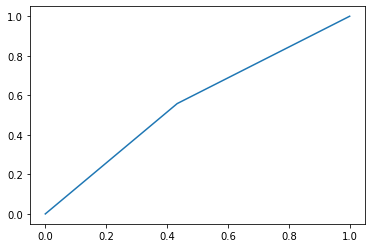

In [114]:
# sklearn에서 ROC 패키지 활용
fpr, tpr, thresholds = roc_curve(test_y,pred_y,pos_label = 1)

# ROC curve
plt.plot(fpr,tpr)

# AUC
auc = np.trapz(tpr,fpr)
print("AUC:",auc)

In [115]:
table_logit = logit[-10:]
table_logit['logit'] = pred_y[-10:]
ratio = results.predict_proba(test_x)[-10:] # [-1,1]
table_logit['up_ratio'] = 0.1
for i in range(10):
  table_logit['up_ratio'].iloc[i] = ratio[i][1]

In [116]:
joblib.dump(results, 'logit_hun_model.pkl')

['logit_hun_model.pkl']

In [117]:
table_logit.to_csv('hun_logit_table.csv', index=False)